<a href="https://colab.research.google.com/github/mcow7j/CACI_coding_challenge/blob/main/mc_coding_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import sleep

In [ ]:
data_in_path = 'https://raw.githubusercontent.com/caci-idg/tech-away-day-22-coding-challenge/main/'

In [ ]:
#import data only reading in columns you actually need
offices = pd.read_csv(data_in_path +'candidate-offices.csv',usecols=['OFFICE_ID','DESCRIPTION'])
cycle = pd.read_csv(data_in_path +'EMP_LOCATIONS_TO_TOP_1000_MSOA_CYCLING_MATRIX.csv')
drive = pd.read_csv(data_in_path +'EMP_LOCATIONS_TO_TOP_1000_MSOA_MATRIX.csv',usecols=['DriveTime (Mins)','DriveDistance (Kilometres)'])
pt = pd.read_csv(data_in_path +'EMP_LOCATIONS_TO_TOP_1000_MSOA_PTN_MATRIX.csv',usecols=['DRIVETIME','DRIVETIME_DISTANCE'])
employeyes = pd.read_csv(data_in_path +'postal-sectors-employee-counts.csv',usecols=['POSTAL_SECTOR','EMP_COUNT'])
co2_costs = {'drive':290,'cycle':0,'pt':100}

In [ ]:
#combine modes of transport data into 1 df with 
all = cycle.rename(columns={'DriveTime (Mins)':'Cycle Time'}).drop(columns = ['DriveDistance (Kilometres)'])
all['Cycle Cost'] = 0 #co2_costs['cycle']
all['Drive Time'] = drive['DriveTime (Mins)']
all['Drive Cost'] = drive['DriveDistance (Kilometres)']*co2_costs['drive']
all['PT Time'] = pt['DRIVETIME']
all['PT Cost'] = pt['DRIVETIME_DISTANCE']*co2_costs['pt']

In [ ]:
#convert to numpy arrays
time_array = all[['Cycle Time','Drive Time','PT Time']].to_numpy()
cost_array = all[['Cycle Cost','Drive Cost','PT Cost']].to_numpy()

In [ ]:
min_time_index= np.argmin(time_array, axis=1)
min_time_costs = np.zeros((858000,2)) #preallocate for effieceny

#choose the mode of transport with shortest transport times, find the co2 cost for that journey as well
#should really use the fact that "Employees commuting time is 50% times more important than travel distance" but it gets messy as both need rescaling/use some order based logic

j=0
for i in min_time_index:
    time = time_array[j,i]
    if time <2147483646:
        min_time_costs[j,:] = [time,cost_array[j,i]]
    j+=1

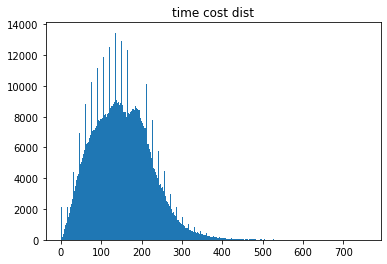

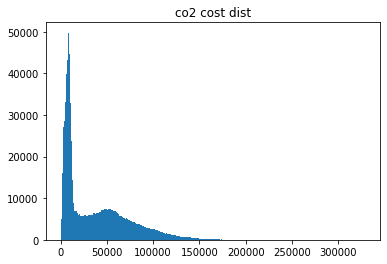

In [ ]:
#ploy distrubtions to makew sure they are comparable 
plt.hist(min_time_costs[:,0], bins='auto') 
plt.title("time cost dist")
plt.show()

plt.hist(min_time_costs[:,1], bins='auto') 
plt.title("co2 cost dist")
plt.show()

In [ ]:
#going to subtract mean and divide by s.d so they are comparable, so they can just be added toegther to work out cost 
#can do those as both distributions are vagly normal

#work out mean and sdt
mean = min_time_costs.mean(axis=0)
sdt = np.std(min_time_costs,axis=0)

#scale

min_time_costs[:,0] = (min_time_costs[:,0]-mean[0])/sdt[0]
min_time_costs[:,1] = (min_time_costs[:,1]-mean[1])/sdt[1]

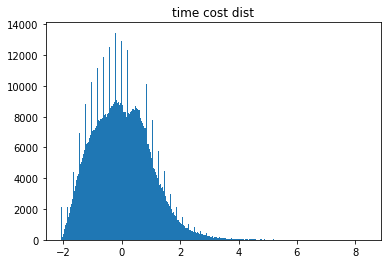

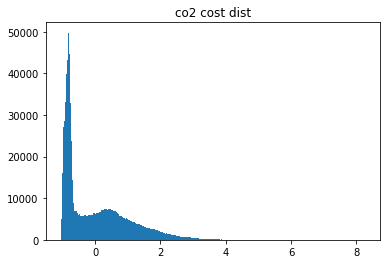

In [ ]:
#ploy distrubtions to makew sure they are comparable 
plt.hist(min_time_costs[:,0], bins='auto') 
plt.title("time cost dist")
plt.show()

plt.hist(min_time_costs[:,1], bins='auto') 
plt.title("co2 cost dist")
plt.show()

In [ ]:
all.drop(columns = ['Cycle Time',
       'Cycle Cost', 'Drive Time', 'Drive Cost', 'PT Time', 'PT Cost'],inplace=True)

all['cost'] = min_time_costs.sum(axis=1)

In [ ]:
employeyes_clean = employeyes[employeyes['EMP_COUNT']>1] #find locations where more then 1 emplee to reduce work of the merge

In [ ]:
all_2 = all.merge(employeyes_clean,how='left',left_on='Origin',right_on='POSTAL_SECTOR').drop(columns=['POSTAL_SECTOR']) #I checked every that at least 1 employee lives at every orgin
all_2['employ weight'] = all_2['EMP_COUNT'].fillna(1) 
all_2['cost'] =all_2['cost']*all_2['employ weight'] #update cost to be represent postcode populations 

In [ ]:
cost_by_location = all_2[['Destination','cost']].groupby('Destination').agg(Sum=('cost', 'sum')).rename(columns={'Sum':'Overall Cost'})
cost_by_location = cost_by_location.merge(offices,how='left',left_on='Destination',right_on='OFFICE_ID')
cost_by_location = cost_by_location[cost_by_location['DESCRIPTION']!='Isle of Wight 012']  # it turns out isle of wight is inacceaasble so has zero costs so has a very negative cost. other wise best location by a long shot is isle of white
best_location_id = cost_by_location['Overall Cost'].idxmin() #best location

In [ ]:
print("And the best location is............." )
sleep(2)
print('drum roll pls')
sleep(2)
print('and more drum roll')
sleep(2)
print(cost_by_location['DESCRIPTION'][best_location_id], 'with office ID {}'.format(cost_by_location['OFFICE_ID'][best_location_id]))

And the best location is.............
drum roll pls
and more drum roll
Westminster 008 with office ID E02000967


In [ ]:
print("Top 10 Locations are: " )
cost_by_location.nsmallest(10, 'Overall Cost')

Top 10 Locations are: 


,Overall Cost,OFFICE_ID,DESCRIPTION
190,-1757.941975,E02000967,Westminster 008
50,-1757.887156,E02000191,Camden 026
195,-1745.340263,E02000972,Westminster 013
176,-1737.328699,E02000924,Wandsworth 002
198,-1734.809301,E02000975,Westminster 016
924,-1732.990569,E02006853,Tower Hamlets 032
149,-1730.367895,E02000813,Southwark 007
152,-1724.960559,E02000820,Southwark 014
197,-1719.544978,E02000974,Westminster 015
911,-1717.862489,E02006801,Lambeth 036
